# Step 1 - Building a text classifier using Term Frequency (TF) and Naive Bayes

Load training and test data

In [1]:
import pandas as pd

# Load training and testing datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [2]:
# Concatenate both Title and Description as text input
train_df['text_input'] = train_df['Title'] + " " + train_df['Description']
test_df['text_input'] = test_df['Title'] + " " + test_df['Description']

Convert Text into Term Frequency (TF) Features

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise CountVectorizer
count_vect = CountVectorizer()

# Fit on training data and transform both train & test data
# Ensures both train and test sets uses the same word representation
X_train = count_vect.fit_transform(train_df['text_input']) #learns the vocab and creates the term-frequency matrix
X_test = count_vect.transform(test_df['text_input']) #applies the learned vocab to the test data

In [4]:
# Extract class labels and convert 1-4 labels to 0-3 for sparse_categorical_crossentropy
y_train = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1

Train & Evaluate Naive Bayes Model

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Train the Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict on both training and test datasets
y_train_pred = nb_classifier.predict(X_train)
y_test_pred = nb_classifier.predict(X_test)

# Compute accuracy
tf_train_accuracy = accuracy_score(y_train, y_train_pred)
tf_test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"TF Training Accuracy: {tf_train_accuracy:.3f}")
print(f"TF Testing Accuracy: {tf_test_accuracy:.3f}")

TF Training Accuracy: 0.917
TF Testing Accuracy: 0.901


# Step 2 - Building a text classifier using TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a TF-IDF vectorizer and transform train & test data
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(train_df['text_input'])  # Fit and transform on training data
X_test_tfidf = tfidf_vect.transform(test_df['text_input'])  # Transform on test data

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Predict on both training and testing data
y_train_pred = nb_classifier.predict(X_train_tfidf)
y_test_pred = nb_classifier.predict(X_test_tfidf)

# Compute accuracy
tf_idf_train_accuracy = accuracy_score(y_train, y_train_pred)
tf_idf_test_accuracy = accuracy_score(y_test, y_test_pred)

# Compute precision, recall, and F1-score
classification_metrics = classification_report(y_test, y_test_pred)

print(f"TF-IDF Training Accuracy: {tf_idf_train_accuracy:.3f}")
print(f"TF-IDF Testing Accuracy: {tf_idf_test_accuracy:.3f}")
print("\nClassification Report (Test Set):\n", classification_metrics)

TF-IDF Training Accuracy: 0.917
TF-IDF Testing Accuracy: 0.902

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.95      0.98      0.96      1900
           2       0.87      0.86      0.86      1900
           3       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



# Step 3 - Building a text classifier using CNN

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [8]:
import numpy as np
from collections import Counter

# use 90th percentile for maxlen for memory efficiency
text_lengths = [len(text.split()) for text in train_df["text_input"]] # get sequence lengths
maxlen = int(np.percentile(text_lengths, 90)) #compute 90th percentile length

# find optimal vocab size
all_words = " ".join(train_df["text_input"]).split()
word_freq = Counter(all_words)
total_unique_words = len(word_freq)
vocab_size = min(50000, total_unique_words) # keep top 50,000 words or all if fewer

In [9]:
# Tokenization & Sequence Conversion
tokenizer = Tokenizer(num_words=vocab_size)  # Keep top K words
tokenizer.fit_on_texts(train_df["text_input"])

# Convert text to integer sequences
X_train_seq = tokenizer.texts_to_sequences(train_df["text_input"])
X_test_seq = tokenizer.texts_to_sequences(test_df["text_input"])

# Post padding sequences to a fixed length (ensuring uniform input size)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post")

In [10]:
# CNN model with random initialisation of embedding layer
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen, trainable=True),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),  # nonlinear fully connected transformation layer
    Dense(4, activation='softmax')  # output layer for 4-class classification
])

In [11]:
# build the model before printing summary
cnn_model.build((None, maxlen))

# print model summary to check output shapes and verify trainable parameters
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 50)            2500000   
                                                                 
 conv1d (Conv1D)             (None, 44, 128)           32128     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2536388 (9.68 MB)
Trainable params: 2536388 (9.68 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [12]:
# Compile model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])

In [13]:
# Train & Track Accuracy
history = cnn_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(X_test_pad, y_test),  # Use test data for validation
    verbose=1
)

Epoch 1/10
235/235 [==============================] - 12s 48ms/step - loss: 0.5075 - sparse_categorical_accuracy: 0.8307 - val_loss: 0.2608 - val_sparse_categorical_accuracy: 0.9141
Epoch 2/10
235/235 [==============================] - 13s 57ms/step - loss: 0.1956 - sparse_categorical_accuracy: 0.9354 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.9113
Epoch 3/10
235/235 [==============================] - 11s 47ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9128
Epoch 4/10
235/235 [==============================] - 11s 48ms/step - loss: 0.1128 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.2897 - val_sparse_categorical_accuracy: 0.9089
Epoch 5/10
235/235 [==============================] - 11s 48ms/step - loss: 0.0908 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.3247 - val_sparse_categorical_accuracy: 0.9051
Epoch 6/10
235/235 [==============================] - 12s 50ms/step - loss: 0.0743 - spars

In [14]:
# Evaluate Model
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_pad, y_test)
print(f"\nFinal Test Accuracy: {test_acc_cnn:.3f}")

238/238 [==============================] - 1s 3ms/step - loss: 0.5271 - sparse_categorical_accuracy: 0.8903

Final Test Accuracy: 0.890


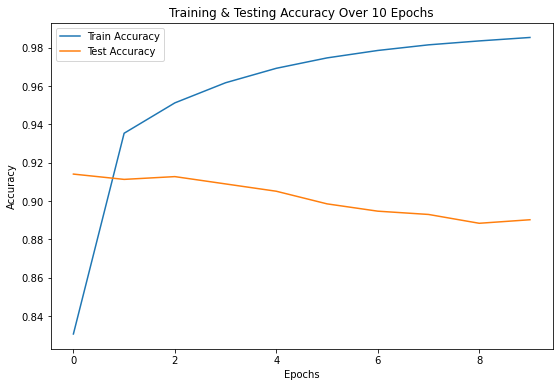

In [15]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(9, 6))
plt.plot(history.history["sparse_categorical_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Testing Accuracy Over 10 Epochs")
plt.legend()
plt.show()

# Step 4 - CNN text classifier using pre-trained word embeddings (GloVe)

In [16]:
# Load pre-trained GloVe Embeddings
glove_dim = 50  # using GloVe.6B.50d (each word is a 50-dimensional vector)
glove_path = "glove.6B.50d.txt"  # path to GloVe file

# Create a dictionary mapping words to their GloVe embeddings
embeddings_index = {}

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # The word itself
        vector = np.asarray(values[1:], dtype="float32")  # the embedding vector
        embeddings_index[word] = vector  # store in dictionary

In [17]:
# Create Embedding Matrix for Vocabulary
# Random initialisation of small random values for words that don't exist in the GloVe vocab
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, glove_dim))  

for word, i in tokenizer.word_index.items():
    if i < vocab_size:  # only keep words in vocab
        embedding_vector = embeddings_index.get(word)  # get GloVe vector
        if embedding_vector is not None: # only assign if word exists in GloVe
            embedding_matrix[i] = embedding_vector  # assign GloVe embedding

In [18]:
# Define CNN Model Using GloVe Embeddings
cnn_model_glove = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=glove_dim, 
              input_length=maxlen, 
              weights=[embedding_matrix],  # load GloVe embeddings
              trainable=True),  # allow training on top of GloVe embeddings
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

In [19]:
# Compile & Train the Model
cnn_model_glove.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])

history_glove = cnn_model_glove.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(X_test_pad, y_test),
    verbose=1
)

Epoch 1/10
235/235 [==============================] - 25s 102ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.3161 - val_sparse_categorical_accuracy: 0.8918
Epoch 2/10
235/235 [==============================] - 20s 86ms/step - loss: 0.2745 - sparse_categorical_accuracy: 0.9085 - val_loss: 0.2753 - val_sparse_categorical_accuracy: 0.9080
Epoch 3/10
235/235 [==============================] - 19s 82ms/step - loss: 0.2306 - sparse_categorical_accuracy: 0.9228 - val_loss: 0.2568 - val_sparse_categorical_accuracy: 0.9114
Epoch 4/10
235/235 [==============================] - 15s 66ms/step - loss: 0.1971 - sparse_categorical_accuracy: 0.9342 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9158
Epoch 5/10
235/235 [==============================] - 15s 64ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.2595 - val_sparse_categorical_accuracy: 0.9139
Epoch 6/10
235/235 [==============================] - 14s 57ms/step - loss: 0.1447 - spar

In [20]:
# Evaluate Model on Test Data
test_loss_cnn_glove, test_acc_cnn_glove = cnn_model_glove.evaluate(X_test_pad, y_test)
print(f"\nFinal Test Accuracy with GloVe: {test_acc_cnn_glove:.3f}")

238/238 [==============================] - 1s 5ms/step - loss: 0.3483 - sparse_categorical_accuracy: 0.9058

Final Test Accuracy with GloVe: 0.906


In [21]:
from sklearn.metrics import confusion_matrix

# Compute & Plot Confusion Matrix
y_test_pred = np.argmax(cnn_model_glove.predict(X_test_pad), axis=1)  # convert probabilities to class predictions
conf_matrix = confusion_matrix(y_test, y_test_pred)

238/238 [==============================] - 2s 5ms/step


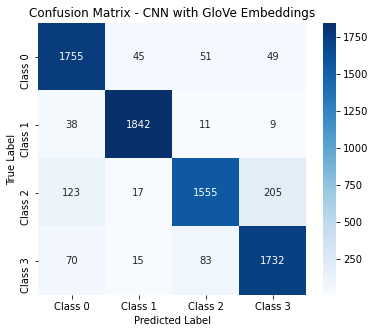

In [22]:
import seaborn as sns
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN with GloVe Embeddings")
plt.show()

# Step 5 - Improved CNN-Based Classifier with Hyperparameter Tuning & Preprocessing

In [23]:
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalAveragePooling1D, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
# re-load training and testing datasets for text preprocessing and tokenisation
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [25]:
#nltk.download('stopwords') #download stopwords
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [26]:
# Text Preprocessing (Removing stopwords, stemming)
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Remove special characters
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords & stem
    return " ".join(words)

train_df["text_input"] = (train_df["Title"] + " " + train_df["Description"]).apply(preprocess_text)
test_df["text_input"] = (test_df["Title"] + " " + test_df["Description"]).apply(preprocess_text)

In [27]:
#Tokenize and pad preprocessed data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_df["text_input"])

X_train_seq = tokenizer.texts_to_sequences(train_df["text_input"])
X_test_seq = tokenizer.texts_to_sequences(test_df["text_input"])

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post")

In [28]:
# Train-Validation Split (Keeping test set unseen)
X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42)

In [29]:
# Add EarlyStopping for training stability and avoid overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [30]:
# Define improved CNN Model with hyperparameter tuning
cnn_model_tuned = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=glove_dim, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True),
    
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Dropout(0.5),  # Adding dropout to prevent overfitting
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    LSTM(64, return_sequences=False),  # Added LSTM layer for better text understanding
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

In [31]:
# Compile & Train the Model (Learning Rate Adjusted)
cnn_model_tuned.compile(optimizer=Adam(learning_rate=1e-4),  # Reduced learning rate
                        loss="sparse_categorical_crossentropy",
                        metrics=["sparse_categorical_accuracy"])

history_tuned = cnn_model_tuned.fit(
    X_train, y_train,
    epochs=15,  
    batch_size=256, 
    validation_data=(X_val, y_val),  # use validation set
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
375/375 [==============================] - 60s 155ms/step - loss: 1.3388 - sparse_categorical_accuracy: 0.3343 - val_loss: 1.2351 - val_sparse_categorical_accuracy: 0.4260
Epoch 2/15
375/375 [==============================] - 53s 140ms/step - loss: 1.1420 - sparse_categorical_accuracy: 0.4846 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.5770
Epoch 3/15
375/375 [==============================] - 52s 138ms/step - loss: 0.9026 - sparse_categorical_accuracy: 0.6161 - val_loss: 0.7446 - val_sparse_categorical_accuracy: 0.6981
Epoch 4/15
375/375 [==============================] - 52s 139ms/step - loss: 0.7216 - sparse_categorical_accuracy: 0.7080 - val_loss: 0.6161 - val_sparse_categorical_accuracy: 0.7611
Epoch 5/15
375/375 [==============================] - 52s 138ms/step - loss: 0.6153 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.5727 - val_sparse_categorical_accuracy: 0.7789
Epoch 6/15
375/375 [==============================] - 51s 137ms/step - loss: 0.5502 -

238/238 [==============================] - 2s 7ms/step - loss: 0.3593 - sparse_categorical_accuracy: 0.8780

 Final Test Accuracy with Hyperparameter Tuning: 0.878
238/238 [==============================] - 2s 6ms/step


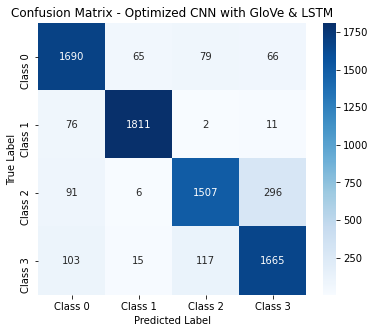

In [32]:
# Evaluate Model on Test Data
test_loss_v1, test_acc_v1 = cnn_model_tuned.evaluate(X_test_pad, y_test)
print(f"\n Final Test Accuracy with Hyperparameter Tuning: {test_acc_v1:.3f}")

# Compute & Plot Confusion Matrix
y_test_pred = np.argmax(cnn_model_tuned.predict(X_test_pad), axis=1)
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Optimized CNN with GloVe & LSTM")
plt.show()

Epoch 1/15
375/375 [==============================] - 49s 126ms/step - loss: 1.4033 - sparse_categorical_accuracy: 0.2722 - val_loss: 1.3685 - val_sparse_categorical_accuracy: 0.2937
Epoch 2/15
375/375 [==============================] - 47s 126ms/step - loss: 1.3200 - sparse_categorical_accuracy: 0.3554 - val_loss: 1.2368 - val_sparse_categorical_accuracy: 0.4378
Epoch 3/15
375/375 [==============================] - 83s 220ms/step - loss: 1.1361 - sparse_categorical_accuracy: 0.4851 - val_loss: 1.0133 - val_sparse_categorical_accuracy: 0.5715
Epoch 4/15
375/375 [==============================] - 74s 197ms/step - loss: 0.9021 - sparse_categorical_accuracy: 0.6166 - val_loss: 0.7567 - val_sparse_categorical_accuracy: 0.7092
Epoch 5/15
375/375 [==============================] - 71s 189ms/step - loss: 0.7069 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.6006 - val_sparse_categorical_accuracy: 0.7750
Epoch 6/15
375/375 [==============================] - 68s 182ms/step - loss: 0.5900 -

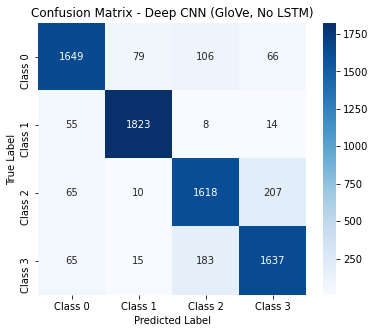

In [33]:
# Try a Deeper CNN without LSTM using
# - 3 Conv1D layers
# - Dropout + Global MaxPooling
# - Fully connected layers with increased units
from tensorflow.keras.layers import GlobalMaxPooling1D

cnn_model_v2 = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=glove_dim, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True),
    
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Dropout(0.4),
    
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Dropout(0.3),
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

cnn_model_v2.compile(optimizer=Adam(learning_rate=1e-4),
                     loss="sparse_categorical_crossentropy",
                     metrics=["sparse_categorical_accuracy"])

history_v2 = cnn_model_v2.fit(
    X_train, y_train,
    epochs=15,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate
test_loss_v2, test_acc_v2 = cnn_model_v2.evaluate(X_test_pad, y_test)
print(f"\Final Test Accuracy - Deep CNN (no LSTM): {test_acc_v2:.3f}")

# Confusion Matrix
y_test_pred_v2 = np.argmax(cnn_model_v2.predict(X_test_pad), axis=1)
conf_matrix_v2 = confusion_matrix(y_test, y_test_pred_v2)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_v2, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Deep CNN (GloVe, No LSTM)")
plt.show()


In [34]:
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Concatenate, Bidirectional, LSTM, Dense, Dropout
)
from tensorflow.keras.models import Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 48, 50)               2500000   ['input_3[0][0]']             
                                                                                                  
 conv1d_13 (Conv1D)          (None, 46, 64)               9664      ['embedding_6[0][0]']         
                                                                                                  
 conv1d_14 (Conv1D)          (None, 45, 64)               12864     ['embedding_6[0][0]']         
                                                                                              

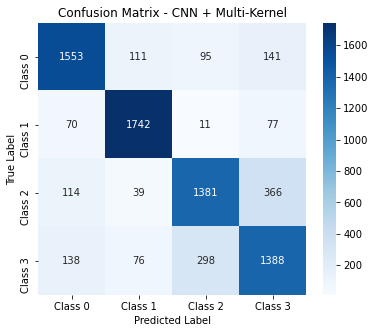

In [37]:
#Try multi-kernel CNN model

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=glove_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(input_layer)

# Multiple convolutional filters (kernel sizes 3, 4, 5)
conv_3 = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)
conv_4 = Conv1D(filters=64, kernel_size=4, activation='relu')(embedding_layer)
conv_5 = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)

pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

# Merge the pooled outputs
merged = Concatenate()([pool_3, pool_4, pool_5])
drop = Dropout(0.5)(merged)

# Dense layers
dense = Dense(64, activation='relu')(drop)
drop_final = Dropout(0.3)(dense)
output = Dense(4, activation='softmax')(drop_final)

# Build model
cnn_model_v3 = Model(inputs=input_layer, outputs=output)
cnn_model_v3.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

cnn_model_v3.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit model
history_v3 = cnn_model_v3.fit(
    X_train, y_train,
    epochs=15,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Final evaluation on unseen test data
test_loss_v3, test_acc_v3 = cnn_model_v3.evaluate(X_test_pad, y_test)
print(f"\ Final Test Accuracy - CNN + Multi-Kernel: {test_acc_v3:.3f}")

# Confusion Matrix
y_test_pred = np.argmax(cnn_model_v3.predict(X_test_pad), axis=1)
conf_matrix_v3 = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_v3, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN + Multi-Kernel")
plt.show()

In [39]:
# Store test accuracy results for all steps
results_summary = pd.DataFrame([
    {
        "Model": "1. Term Frequency + Naive Bayes",
        "Test Accuracy": tf_test_accuracy,
        "Notes": "Used CountVectorizer (TF) and Multinomial Naive Bayes classifier"
    },
    {
        "Model": "2. TF-IDF + Naive Bayes",
        "Test Accuracy": tf_idf_test_accuracy,
        "Notes": "Used TfidfVectorizer instead of TF"
    },
    {
        "Model": "3. CNN (Random Initialised Embeddings)",
        "Test Accuracy": test_acc_cnn,
        "Notes": "Embedding layer initialized randomly, trained with Conv1D, no pre-trained vectors"
    },
    {
        "Model": "4. CNN + GloVe (Pre-trained)",
        "Test Accuracy": test_acc_cnn_glove,
        "Notes": "Used GloVe.6B.50d embeddings; trainable layer"
    },
    {
        "Model": "5. CNN + GloVe + Tuning + LSTM",
        "Test Accuracy": test_acc_v1,
        "Notes": (
            "Preprocessing (stopwords + stemming), Bidirectional LSTM, "
            "Dropout, reduced learning rate, tuned batch size, early stopping"
        )
    },
    {
        "Model": "6. (Variant): Deep CNN + GloVe (No LSTM)",
        "Test Accuracy": test_acc_v2,
        "Notes": (
            "Deeper CNN with 3 Conv1D layers, GlobalMaxPooling, Dropout, "
            "no LSTM; focused on hierarchical feature extraction"
        )
    },
    {
        "Model": "7. (Variant): CNN + Multi-Kernel",
        "Test Accuracy": test_acc_v3,
        "Notes": (
            "Tested kernel sizes (3, 4, 5);"
        )
    }
])

print("Summary of Test Accuracy Across All Models:")
display(results_summary.sort_values("Test Accuracy", ascending=False))

Summary of Test Accuracy Across All Models:


,Model,Test Accuracy,Notes
3,4. CNN + GloVe (Pre-trained),0.905789,Used GloVe.6B.50d embeddings; trainable layer
1,2. TF-IDF + Naive Bayes,0.902237,Used TfidfVectorizer instead of TF
0,1. Term Frequency + Naive Bayes,0.900921,Used CountVectorizer (TF) and Multinomial Naiv...
2,3. CNN (Random Initialised Embeddings),0.890263,"Embedding layer initialized randomly, trained ..."
5,6. (Variant): Deep CNN + GloVe (No LSTM),0.885132,"Deeper CNN with 3 Conv1D layers, GlobalMaxPool..."
4,5. CNN + GloVe + Tuning + LSTM,0.878026,"Preprocessing (stopwords + stemming), Bidirect..."
6,7. (Variant): CNN + Multi-Kernel,0.797895,"Tested kernel sizes (3, 4, 5);"


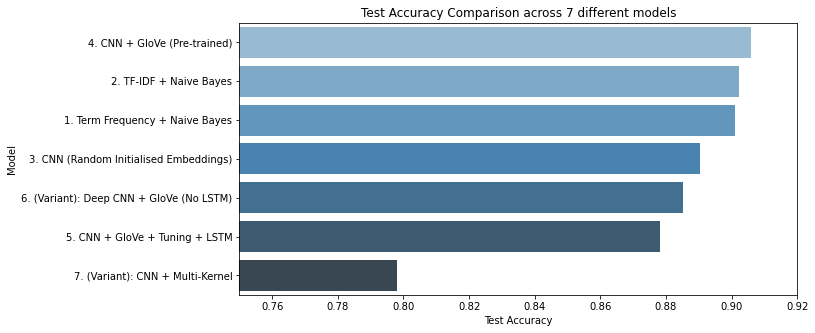

In [43]:
plt.figure(figsize=(10, 5))
sns.barplot(data=results_summary.sort_values("Test Accuracy", ascending=False), x="Test Accuracy", y="Model", palette="Blues_d")
plt.title("Test Accuracy Comparison across 7 different models")
plt.xlim(0.75, 0.92)
plt.xlabel("Test Accuracy")
plt.ylabel("Model")
plt.show()